In [1]:
import pandas as pd
import re
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2024-05-05 01:14:52.866070: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-05 01:14:52.866297: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-05 01:14:52.868171: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-05 01:14:52.890255: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-05 01:14:53.485577: W tensorflow/compiler/tf2tensorrt/utils/py_uti

In [2]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [3]:
# # Loading the dataset (using the downloaded file)
# path = "/content/drive/MyDrive/Colab Notebooks/DATA255_Assignment/IMDB_Dataset.csv"
# df = pd.read_csv(path)

In [4]:
df= pd.read_csv("IMDB_Dataset.csv")
df.head()

,review,sentiment
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
##cleaning up the text
stopWords = set(nltk.corpus.stopwords.words("english"))
def CleanText(text):
    text = text.lower()
    text = re.sub("[^a-z]", " ", text)
    words = [word for word in text.split() if word not in stopWords]
    text = " ".join(words)
    return text

df["review"]=df.apply(lambda row: CleanText(row["review"]), axis=1)
Data = df.review
labels = df.sentiment

In [7]:
### converting 1000 most frequent words to integer
frequentWord = 10000
tokenizer = Tokenizer(num_words=frequentWord)

tokenizer.fit_on_texts(Data)

IntegerizedData = pd.Series(tokenizer.texts_to_sequences(Data))
IntegerizedData.head()

0    [315, 6873, 3237, 2, 117, 996, 1569, 1033, 117...
1    [342, 2080, 100, 30, 3711, 232, 11, 66, 165, 5...
2    [20, 595, 4986, 24, 8579, 369, 844, 7247, 2536...
3    [8, 5767, 24, 749, 582, 180, 304, 147, 2329, 2...
4    [8836, 1155, 25, 3325, 521, 11, 535, 9224, 920...
dtype: object

In [8]:
### You can convert the sequences back to the string
tokenizer.sequences_to_texts(IntegerizedData[0:1])

['mr costner dragged movie far longer necessary aside terrific sea rescue sequences care characters us ghosts closet costner character realized early forgotten much later time care character really care cocky ashton kutcher problem comes kid thinks better anyone else around shows signs closet appears winning costner finally well past half way point stinker costner tells us kutcher ghosts told kutcher driven best prior magic could keep turning hour']

In [9]:
DataLength=IntegerizedData.apply(lambda x: len(x))
DataLength.describe()

count    50000.000000
mean       110.157100
std         81.213625
min          3.000000
25%         60.000000
50%         83.000000
75%        135.000000
max       1104.000000
dtype: float64

The average length of reviews is 110, the shortest review length is 3 and the longest is 1104.

Therefore we need to pad the sequences to equal length.

The following padding function performs zero padding if the length of a sequence is less than the threshold and truncate the ones which are longer than threshold to the threshold.  We choose the threshold to be 256.

In [10]:
#zero padding
IntegerizedData= pad_sequences(IntegerizedData, maxlen=256)


In [11]:
IntegerizedData

array([[   0,    0,    0, ...,  269, 1456,  397],
       [   0,    0,    0, ...,  363,    3,   80],
       [   0,    0,    0, ...,   54,   57,   76],
       ...,
       [   0,    0,    0, ...,  973,   99, 9907],
       [   0,    0,    0, ..., 8508, 3506,   13],
       [   0,    0,    0, ...,   11, 2263,   23]], dtype=int32)

In [12]:
x_train_val,x_test,y_train_val,y_test = train_test_split(IntegerizedData,labels,stratify=labels,test_size=0.20, random_state=42)
x_train,x_val,y_train,y_val = train_test_split(x_train_val,y_train_val,stratify=y_train_val,test_size=0.10, random_state=42)

In [13]:
type(x_val)

numpy.ndarray

In [14]:
print(y_train.shape,y_val.shape,y_test.shape)

(36000,) (4000,) (10000,)


## now you have your training, validation and test set as numpy arrays, you can implement the networks

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import time

In [16]:
# Define RNN Classifier model
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        output = self.fc(output[:, -1, :])  # Get the output from the last time step
        output = self.sigmoid(output)
        return output.squeeze(1)

# Define device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Epoch 1/80, Time: 1.28s, Train Loss: 0.6389, Val Loss: 0.6265, Train Accuracy: 0.6281, Val Accuracy: 0.6540
Epoch 2/80, Time: 1.13s, Train Loss: 0.5247, Val Loss: 0.5356, Train Accuracy: 0.7486, Val Accuracy: 0.7555
Epoch 3/80, Time: 1.13s, Train Loss: 0.4629, Val Loss: 0.5072, Train Accuracy: 0.7939, Val Accuracy: 0.7680
Epoch 4/80, Time: 1.14s, Train Loss: 0.4359, Val Loss: 0.4732, Train Accuracy: 0.8123, Val Accuracy: 0.7953
Epoch 5/80, Time: 1.12s, Train Loss: 0.4978, Val Loss: 0.5065, Train Accuracy: 0.7644, Val Accuracy: 0.7650
Epoch 6/80, Time: 1.16s, Train Loss: 0.4180, Val Loss: 0.4683, Train Accuracy: 0.8224, Val Accuracy: 0.7937
Epoch 7/80, Time: 1.15s, Train Loss: 0.3798, Val Loss: 0.4594, Train Accuracy: 0.8436, Val Accuracy: 0.8033
Epoch 8/80, Time: 1.18s, Train Loss: 0.3475, Val Loss: 0.4519, Train Accuracy: 0.8618, Val Accuracy: 0.8040
Epoch 9/80, Time: 1.13s, Train Loss: 0.3181, Val Loss: 0.4363, Train Accuracy: 0.8770, Val Accuracy: 0.8217
Epoch 10/80, Time: 1.11s, Tr

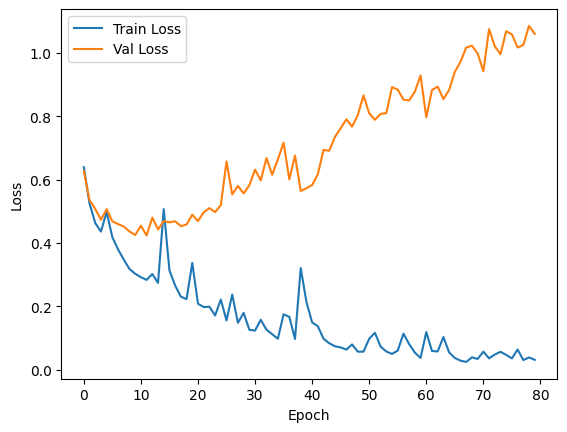

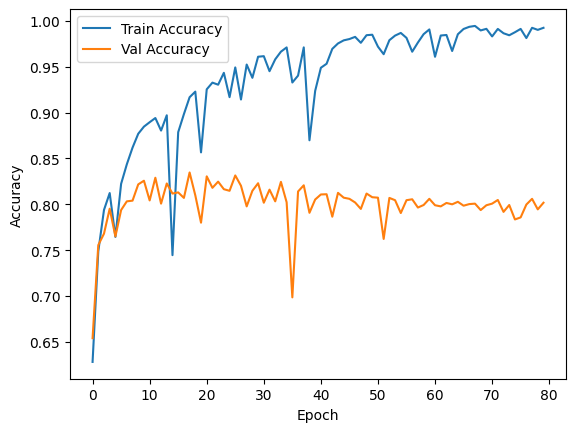

Test Accuracy: 0.8018


In [17]:
# Convert data to PyTorch tensors and move to GPU
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.001
num_epochs = 80

# Instantiate the model and move it to GPU
model = RNNClassifier(vocab_size=frequentWord, embedding_dim=embedding_dim, hidden_dim=hidden_dim).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

## Gradient Clipping with norm 1

Epoch 1/80, Time: 1.95s, Train Loss: 0.6124, Val Loss: 0.5394, Train Accuracy: 0.6589, Val Accuracy: 0.7445
Epoch 2/80, Time: 1.82s, Train Loss: 0.4833, Val Loss: 0.4704, Train Accuracy: 0.7799, Val Accuracy: 0.7885
Epoch 3/80, Time: 1.95s, Train Loss: 0.4038, Val Loss: 0.4170, Train Accuracy: 0.8305, Val Accuracy: 0.8233
Epoch 4/80, Time: 1.95s, Train Loss: 0.3608, Val Loss: 0.3914, Train Accuracy: 0.8565, Val Accuracy: 0.8373
Epoch 5/80, Time: 1.91s, Train Loss: 0.3183, Val Loss: 0.3896, Train Accuracy: 0.8768, Val Accuracy: 0.8440
Epoch 6/80, Time: 1.88s, Train Loss: 0.2867, Val Loss: 0.3830, Train Accuracy: 0.8911, Val Accuracy: 0.8462
Epoch 7/80, Time: 1.92s, Train Loss: 0.2590, Val Loss: 0.3773, Train Accuracy: 0.9041, Val Accuracy: 0.8460
Epoch 8/80, Time: 1.90s, Train Loss: 0.2357, Val Loss: 0.3716, Train Accuracy: 0.9137, Val Accuracy: 0.8482
Epoch 9/80, Time: 1.96s, Train Loss: 0.2097, Val Loss: 0.4097, Train Accuracy: 0.9255, Val Accuracy: 0.8542
Epoch 10/80, Time: 1.97s, Tr

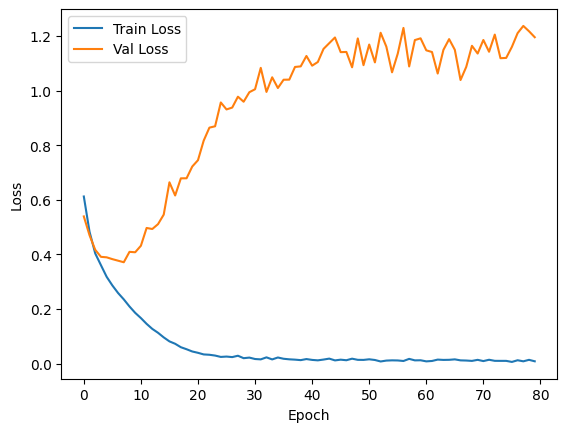

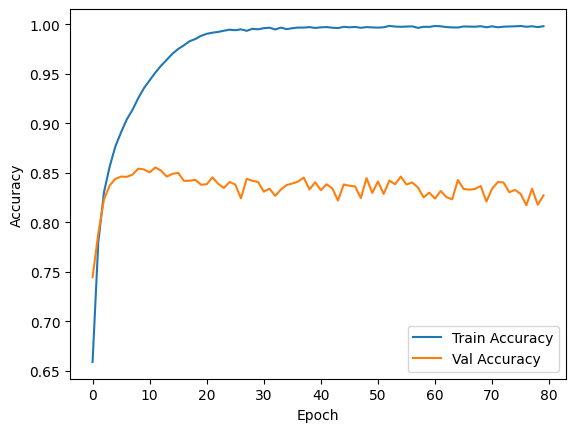

Test Accuracy: 0.8292


In [18]:
# Convert data to PyTorch tensors and move to GPU
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.001
num_epochs = 80

# Instantiate the model and move it to GPU
model = RNNClassifier(vocab_size=frequentWord, embedding_dim=embedding_dim, hidden_dim=hidden_dim).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with gradient clipping
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Adjust max_norm as needed

        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

## Changing the batch size to 512

Epoch 1/80, Time: 2.45s, Train Loss: 0.6797, Val Loss: 0.6405, Train Accuracy: 0.5604, Val Accuracy: 0.6405
Epoch 2/80, Time: 0.37s, Train Loss: 0.5905, Val Loss: 0.5660, Train Accuracy: 0.6919, Val Accuracy: 0.7163
Epoch 3/80, Time: 0.32s, Train Loss: 0.5265, Val Loss: 0.5242, Train Accuracy: 0.7484, Val Accuracy: 0.7450
Epoch 4/80, Time: 2.29s, Train Loss: 0.4599, Val Loss: 0.4666, Train Accuracy: 0.7917, Val Accuracy: 0.7900
Epoch 5/80, Time: 0.32s, Train Loss: 0.4170, Val Loss: 0.4420, Train Accuracy: 0.8194, Val Accuracy: 0.8033
Epoch 6/80, Time: 0.33s, Train Loss: 0.3841, Val Loss: 0.4160, Train Accuracy: 0.8401, Val Accuracy: 0.8177
Epoch 7/80, Time: 2.31s, Train Loss: 0.3538, Val Loss: 0.3916, Train Accuracy: 0.8558, Val Accuracy: 0.8417
Epoch 8/80, Time: 0.35s, Train Loss: 0.3340, Val Loss: 0.3921, Train Accuracy: 0.8653, Val Accuracy: 0.8415
Epoch 9/80, Time: 0.32s, Train Loss: 0.3195, Val Loss: 0.3827, Train Accuracy: 0.8743, Val Accuracy: 0.8522
Epoch 10/80, Time: 2.29s, Tr

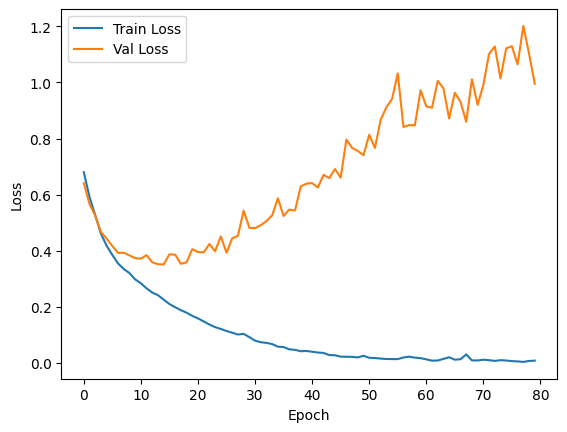

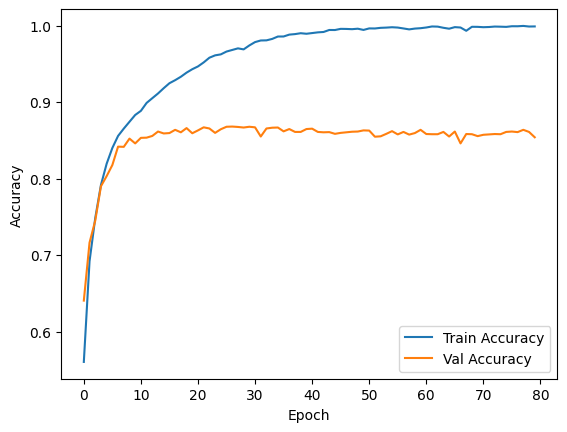

Test Accuracy: 0.8414


In [19]:
# Convert data to PyTorch tensors and move to GPU
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.001
num_epochs = 80

# Instantiate the model and move it to GPU
model = RNNClassifier(vocab_size=frequentWord, embedding_dim=embedding_dim, hidden_dim=hidden_dim).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with gradient clipping
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Adjust max_norm as needed

        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

## L2 Regularization with weight decay of 1e-4

Epoch 1/80, Time: 2.44s, Train Loss: 0.6835, Val Loss: 0.6607, Train Accuracy: 0.5504, Val Accuracy: 0.6038
Epoch 2/80, Time: 0.33s, Train Loss: 0.6391, Val Loss: 0.6202, Train Accuracy: 0.6385, Val Accuracy: 0.6590
Epoch 3/80, Time: 0.32s, Train Loss: 0.5934, Val Loss: 0.5778, Train Accuracy: 0.6898, Val Accuracy: 0.7040
Epoch 4/80, Time: 2.25s, Train Loss: 0.5499, Val Loss: 0.5410, Train Accuracy: 0.7289, Val Accuracy: 0.7378
Epoch 5/80, Time: 0.31s, Train Loss: 0.5066, Val Loss: 0.5237, Train Accuracy: 0.7635, Val Accuracy: 0.7582
Epoch 6/80, Time: 0.33s, Train Loss: 0.4786, Val Loss: 0.4898, Train Accuracy: 0.7824, Val Accuracy: 0.7820
Epoch 7/80, Time: 2.23s, Train Loss: 0.4412, Val Loss: 0.4577, Train Accuracy: 0.8053, Val Accuracy: 0.8025
Epoch 8/80, Time: 0.32s, Train Loss: 0.4296, Val Loss: 0.4480, Train Accuracy: 0.8141, Val Accuracy: 0.8003
Epoch 9/80, Time: 0.34s, Train Loss: 0.4033, Val Loss: 0.4690, Train Accuracy: 0.8266, Val Accuracy: 0.8045
Epoch 10/80, Time: 2.29s, Tr

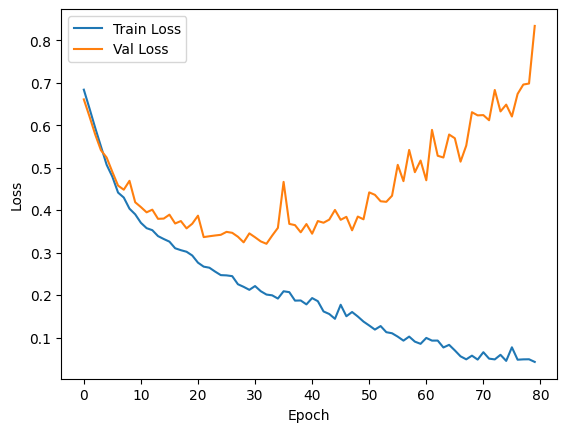

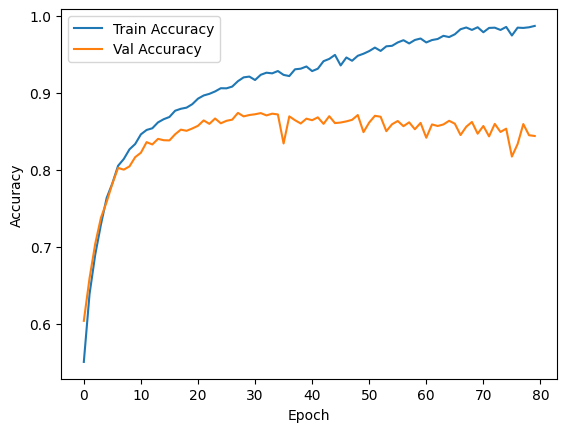

Test Accuracy: 0.8520


In [20]:
# Convert data to PyTorch tensors and move to GPU
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.001
num_epochs = 80

# Instantiate the model and move it to GPU
model = RNNClassifier(vocab_size=frequentWord, embedding_dim=embedding_dim, hidden_dim=hidden_dim).to(device)

# Define loss function and optimizer with L2 regularization (weight decay)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)  # Add weight decay here

# Training loop with gradient clipping
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Adjust max_norm as needed

        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

## Adding dropout with dropout probability of 0.05 & Weight decay of 1e-3

In [21]:
# Define RNN Classifier model with dropout
class RNNClassifierWithDropout(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout_prob=0.05): ### Dropout prob of 0.05 gave better results
        super(RNNClassifierWithDropout, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        output = self.dropout(output)  # Apply dropout to the RNN output
        output = self.fc(output[:, -1, :])  # Get the output from the last time step
        output = self.sigmoid(output)
        return output.squeeze(1)

Epoch 1/80, Time: 0.33s, Train Loss: 0.6985, Val Loss: 0.6964, Train Accuracy: 0.5056, Val Accuracy: 0.5075
Epoch 2/80, Time: 0.32s, Train Loss: 0.6932, Val Loss: 0.6925, Train Accuracy: 0.5201, Val Accuracy: 0.5205
Epoch 3/80, Time: 0.32s, Train Loss: 0.6900, Val Loss: 0.6897, Train Accuracy: 0.5290, Val Accuracy: 0.5265
Epoch 4/80, Time: 0.32s, Train Loss: 0.6875, Val Loss: 0.6876, Train Accuracy: 0.5393, Val Accuracy: 0.5357
Epoch 5/80, Time: 0.31s, Train Loss: 0.6849, Val Loss: 0.6857, Train Accuracy: 0.5439, Val Accuracy: 0.5450
Epoch 6/80, Time: 0.33s, Train Loss: 0.6832, Val Loss: 0.6839, Train Accuracy: 0.5502, Val Accuracy: 0.5475
Epoch 7/80, Time: 0.50s, Train Loss: 0.6808, Val Loss: 0.6819, Train Accuracy: 0.5587, Val Accuracy: 0.5543
Epoch 8/80, Time: 0.32s, Train Loss: 0.6775, Val Loss: 0.6790, Train Accuracy: 0.5671, Val Accuracy: 0.5657
Epoch 9/80, Time: 0.32s, Train Loss: 0.6724, Val Loss: 0.6724, Train Accuracy: 0.5802, Val Accuracy: 0.5813
Epoch 10/80, Time: 0.31s, Tr

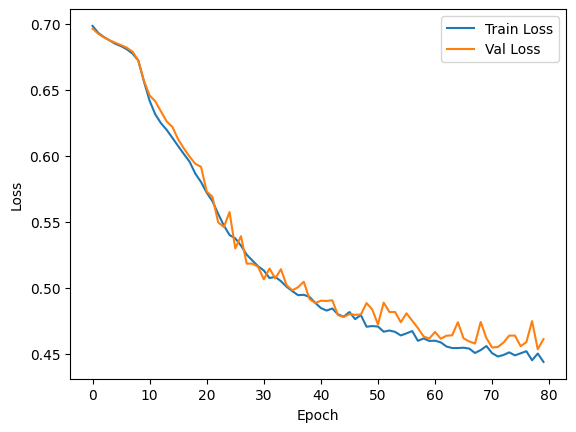

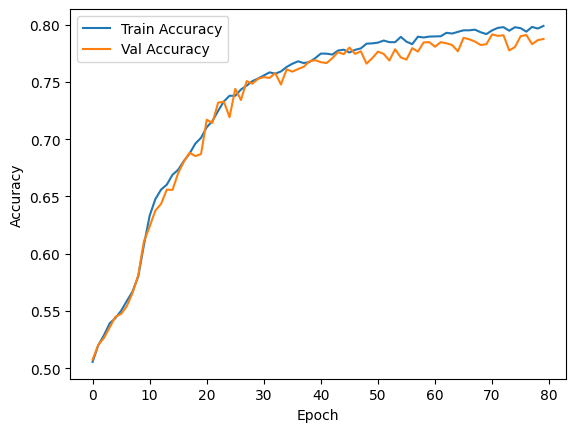

Test Accuracy: 0.7880


In [22]:
# Convert data to PyTorch tensors and move to GPU
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 80

# Instantiate the model and move it to GPU
model = RNNClassifierWithDropout(vocab_size=frequentWord, embedding_dim=embedding_dim, hidden_dim=hidden_dim).to(device)

# Define loss function and optimizer with L2 regularization (weight decay)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-3)  # Add weight decay here

# Training loop with gradient clipping
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Adjust max_norm as needed

        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

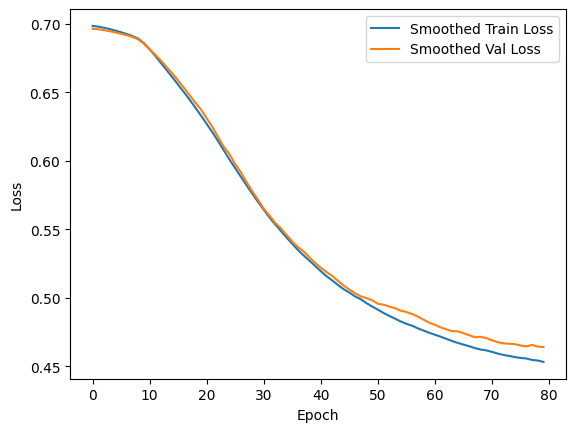

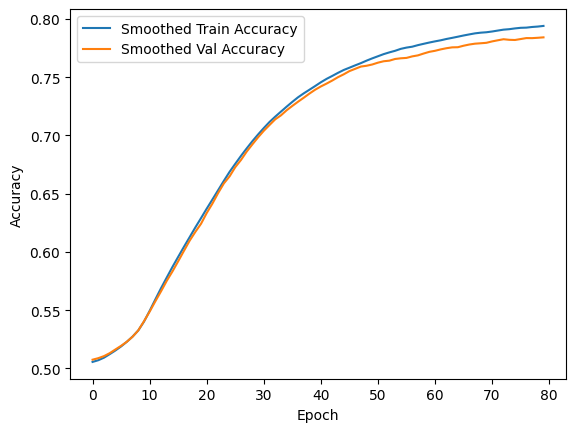

Test Accuracy: 0.7880


In [23]:
### Smoothing out the above graph
import numpy as np
import matplotlib.pyplot as plt

# Define a function for smoothing the data
def smooth_data(data, smoothing_factor=0.9):
    smoothed_data = []
    last_smoothed_point = data[0]
    for point in data:
        smoothed_point = last_smoothed_point * smoothing_factor + point * (1 - smoothing_factor)
        smoothed_data.append(smoothed_point)
        last_smoothed_point = smoothed_point
    return smoothed_data

# Smooth the train and validation losses
smoothed_train_losses = smooth_data(train_losses)
smoothed_val_losses = smooth_data(val_losses)

# Smooth the train and validation accuracies
smoothed_train_accuracies = smooth_data(train_accuracies)
smoothed_val_accuracies = smooth_data(val_accuracies)

# Plotting smoothed train and validation losses
plt.plot(smoothed_train_losses, label='Smoothed Train Loss')
plt.plot(smoothed_val_losses, label='Smoothed Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting smoothed train and validation accuracies
plt.plot(smoothed_train_accuracies, label='Smoothed Train Accuracy')
plt.plot(smoothed_val_accuracies, label='Smoothed Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

## Adding dropout with dropout probability of 0.05 & Weight decay of 1e-4

Epoch 1/80, Time: 0.33s, Train Loss: 0.7005, Val Loss: 0.6980, Train Accuracy: 0.4974, Val Accuracy: 0.5040
Epoch 2/80, Time: 0.52s, Train Loss: 0.6945, Val Loss: 0.6934, Train Accuracy: 0.5129, Val Accuracy: 0.5142
Epoch 3/80, Time: 0.32s, Train Loss: 0.6903, Val Loss: 0.6899, Train Accuracy: 0.5315, Val Accuracy: 0.5300
Epoch 4/80, Time: 0.31s, Train Loss: 0.6872, Val Loss: 0.6871, Train Accuracy: 0.5424, Val Accuracy: 0.5403
Epoch 5/80, Time: 0.33s, Train Loss: 0.6849, Val Loss: 0.6844, Train Accuracy: 0.5492, Val Accuracy: 0.5505
Epoch 6/80, Time: 0.34s, Train Loss: 0.6820, Val Loss: 0.6814, Train Accuracy: 0.5582, Val Accuracy: 0.5610
Epoch 7/80, Time: 0.33s, Train Loss: 0.6785, Val Loss: 0.6773, Train Accuracy: 0.5659, Val Accuracy: 0.5685
Epoch 8/80, Time: 0.32s, Train Loss: 0.6716, Val Loss: 0.6637, Train Accuracy: 0.5846, Val Accuracy: 0.5980
Epoch 9/80, Time: 0.33s, Train Loss: 0.6454, Val Loss: 0.6355, Train Accuracy: 0.6269, Val Accuracy: 0.6448
Epoch 10/80, Time: 0.33s, Tr

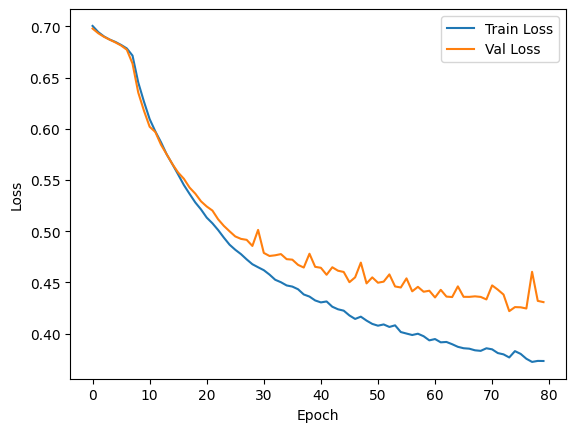

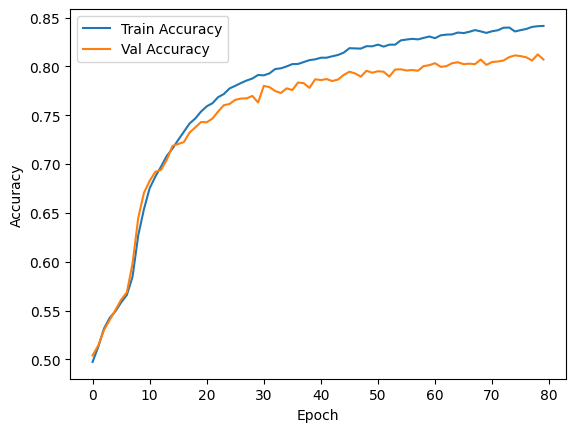

Test Accuracy: 0.8096


In [24]:
# Convert data to PyTorch tensors and move to GPU
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 80

# Instantiate the model and move it to GPU
model = RNNClassifierWithDropout(vocab_size=frequentWord, embedding_dim=embedding_dim, hidden_dim=hidden_dim).to(device)

# Define loss function and optimizer with L2 regularization (weight decay)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)  # Add weight decay here

# Training loop with gradient clipping
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Adjust max_norm as needed

        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

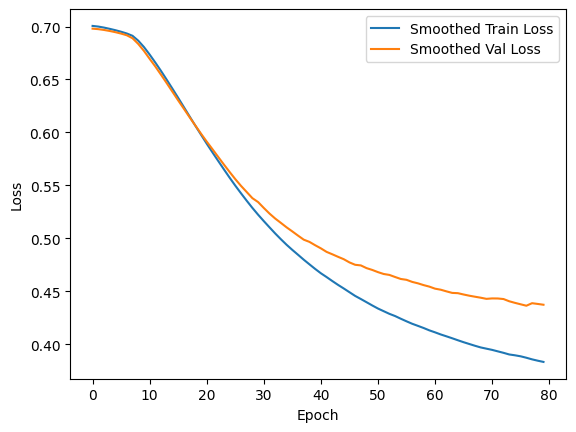

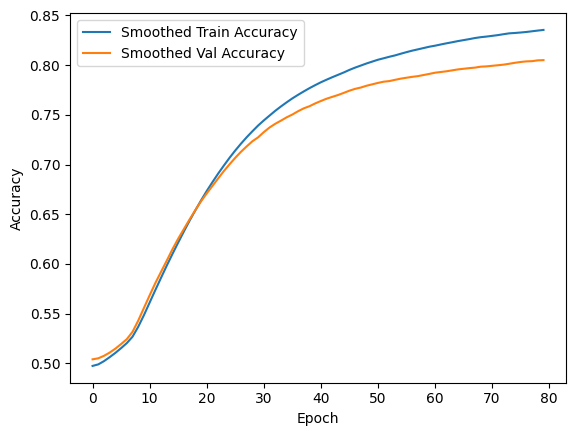

Test Accuracy: 0.8096


In [25]:
### Smoothing out the above graph
import numpy as np
import matplotlib.pyplot as plt

# Define a function for smoothing the data
def smooth_data(data, smoothing_factor=0.9):
    smoothed_data = []
    last_smoothed_point = data[0]
    for point in data:
        smoothed_point = last_smoothed_point * smoothing_factor + point * (1 - smoothing_factor)
        smoothed_data.append(smoothed_point)
        last_smoothed_point = smoothed_point
    return smoothed_data

# Smooth the train and validation losses
smoothed_train_losses = smooth_data(train_losses)
smoothed_val_losses = smooth_data(val_losses)

# Smooth the train and validation accuracies
smoothed_train_accuracies = smooth_data(train_accuracies)
smoothed_val_accuracies = smooth_data(val_accuracies)

# Plotting smoothed train and validation losses
plt.plot(smoothed_train_losses, label='Smoothed Train Loss')
plt.plot(smoothed_val_losses, label='Smoothed Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting smoothed train and validation accuracies
plt.plot(smoothed_train_accuracies, label='Smoothed Train Accuracy')
plt.plot(smoothed_val_accuracies, label='Smoothed Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

## Adding dropout with dropout probability of 0.05 & Weight decay of 5e-4

Epoch 1/80, Time: 0.35s, Train Loss: 0.6966, Val Loss: 0.6924, Train Accuracy: 0.5182, Val Accuracy: 0.5360
Epoch 2/80, Time: 0.34s, Train Loss: 0.6903, Val Loss: 0.6878, Train Accuracy: 0.5368, Val Accuracy: 0.5535
Epoch 3/80, Time: 0.34s, Train Loss: 0.6864, Val Loss: 0.6846, Train Accuracy: 0.5462, Val Accuracy: 0.5700
Epoch 4/80, Time: 0.32s, Train Loss: 0.6829, Val Loss: 0.6816, Train Accuracy: 0.5565, Val Accuracy: 0.5753
Epoch 5/80, Time: 0.52s, Train Loss: 0.6798, Val Loss: 0.6783, Train Accuracy: 0.5618, Val Accuracy: 0.5740
Epoch 6/80, Time: 0.32s, Train Loss: 0.6748, Val Loss: 0.6719, Train Accuracy: 0.5736, Val Accuracy: 0.5833
Epoch 7/80, Time: 0.33s, Train Loss: 0.6638, Val Loss: 0.6537, Train Accuracy: 0.5957, Val Accuracy: 0.6142
Epoch 8/80, Time: 0.32s, Train Loss: 0.6501, Val Loss: 0.6392, Train Accuracy: 0.6212, Val Accuracy: 0.6360
Epoch 9/80, Time: 0.33s, Train Loss: 0.6418, Val Loss: 0.6325, Train Accuracy: 0.6318, Val Accuracy: 0.6498
Epoch 10/80, Time: 0.33s, Tr

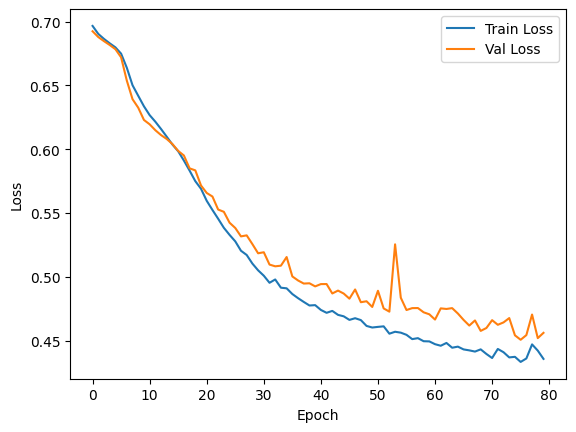

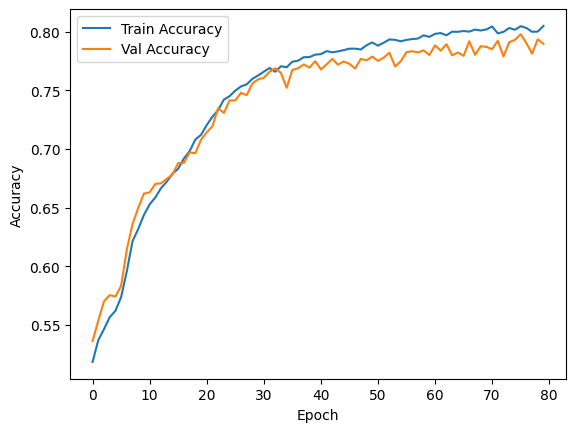

Test Accuracy: 0.7882


In [26]:
# Convert data to PyTorch tensors and move to GPU
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 80

# Instantiate the model and move it to GPU
model = RNNClassifierWithDropout(vocab_size=frequentWord, embedding_dim=embedding_dim, hidden_dim=hidden_dim).to(device)

# Define loss function and optimizer with L2 regularization (weight decay)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)  # Add weight decay here

# Training loop with gradient clipping
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Adjust max_norm as needed

        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

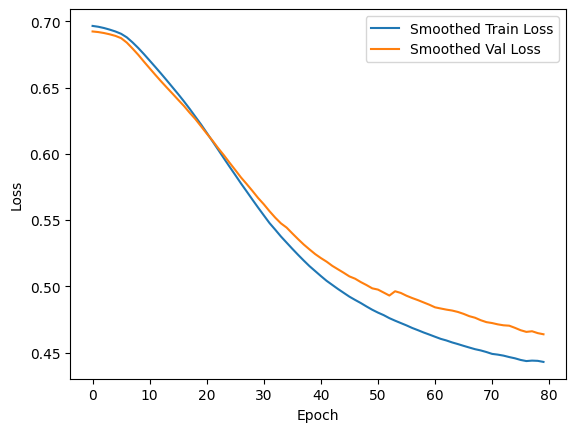

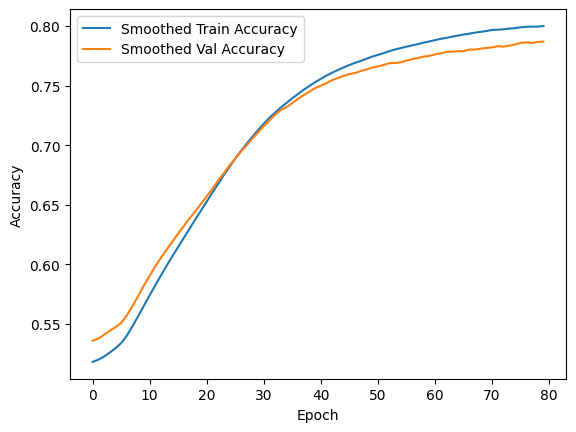

Test Accuracy: 0.7882


In [27]:
### Smoothing out the above graph
import numpy as np
import matplotlib.pyplot as plt

# Define a function for smoothing the data
def smooth_data(data, smoothing_factor=0.9):
    smoothed_data = []
    last_smoothed_point = data[0]
    for point in data:
        smoothed_point = last_smoothed_point * smoothing_factor + point * (1 - smoothing_factor)
        smoothed_data.append(smoothed_point)
        last_smoothed_point = smoothed_point
    return smoothed_data

# Smooth the train and validation losses
smoothed_train_losses = smooth_data(train_losses)
smoothed_val_losses = smooth_data(val_losses)

# Smooth the train and validation accuracies
smoothed_train_accuracies = smooth_data(train_accuracies)
smoothed_val_accuracies = smooth_data(val_accuracies)

# Plotting smoothed train and validation losses
plt.plot(smoothed_train_losses, label='Smoothed Train Loss')
plt.plot(smoothed_val_losses, label='Smoothed Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting smoothed train and validation accuracies
plt.plot(smoothed_train_accuracies, label='Smoothed Train Accuracy')
plt.plot(smoothed_val_accuracies, label='Smoothed Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

## Adding dropout with dropout probability of 0.05 & Weight decay of 3e-4

Epoch 1/80, Time: 0.31s, Train Loss: 0.7018, Val Loss: 0.6979, Train Accuracy: 0.4981, Val Accuracy: 0.5050
Epoch 2/80, Time: 0.32s, Train Loss: 0.6955, Val Loss: 0.6932, Train Accuracy: 0.5142, Val Accuracy: 0.5180
Epoch 3/80, Time: 0.33s, Train Loss: 0.6920, Val Loss: 0.6899, Train Accuracy: 0.5275, Val Accuracy: 0.5295
Epoch 4/80, Time: 0.54s, Train Loss: 0.6890, Val Loss: 0.6873, Train Accuracy: 0.5374, Val Accuracy: 0.5353
Epoch 5/80, Time: 0.33s, Train Loss: 0.6865, Val Loss: 0.6847, Train Accuracy: 0.5468, Val Accuracy: 0.5485
Epoch 6/80, Time: 0.33s, Train Loss: 0.6843, Val Loss: 0.6820, Train Accuracy: 0.5529, Val Accuracy: 0.5573
Epoch 7/80, Time: 0.33s, Train Loss: 0.6817, Val Loss: 0.6782, Train Accuracy: 0.5600, Val Accuracy: 0.5673
Epoch 8/80, Time: 0.32s, Train Loss: 0.6765, Val Loss: 0.6690, Train Accuracy: 0.5780, Val Accuracy: 0.5855
Epoch 9/80, Time: 0.31s, Train Loss: 0.6548, Val Loss: 0.6445, Train Accuracy: 0.6151, Val Accuracy: 0.6232
Epoch 10/80, Time: 0.31s, Tr

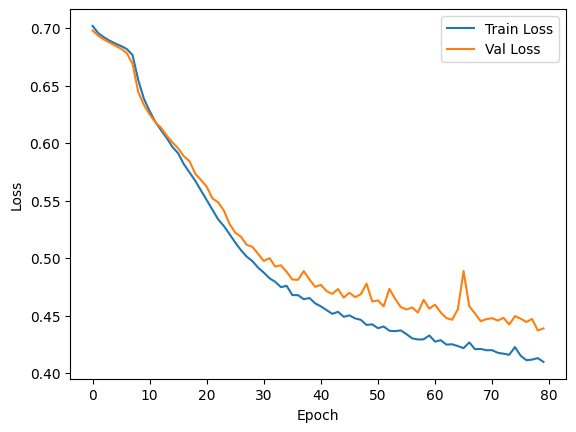

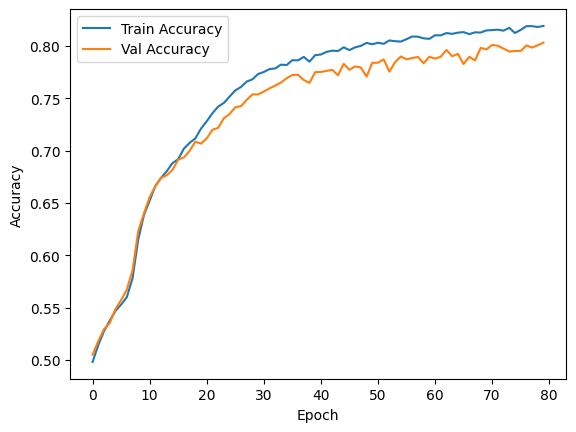

Test Accuracy: 0.7990


In [28]:
# Convert data to PyTorch tensors and move to GPU
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 80

# Instantiate the model and move it to GPU
model = RNNClassifierWithDropout(vocab_size=frequentWord, embedding_dim=embedding_dim, hidden_dim=hidden_dim).to(device)

# Define loss function and optimizer with L2 regularization (weight decay)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=3e-4)  # Add weight decay here

# Training loop with gradient clipping
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Adjust max_norm as needed

        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

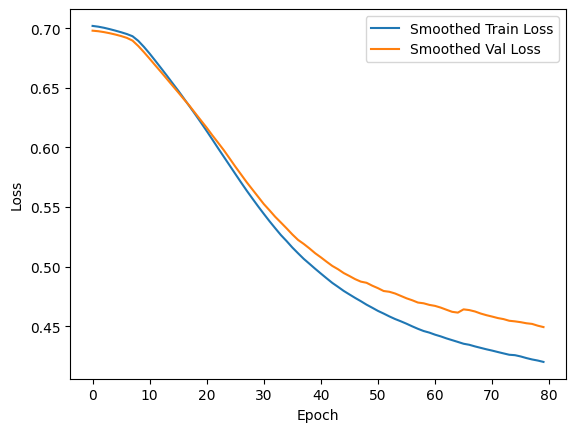

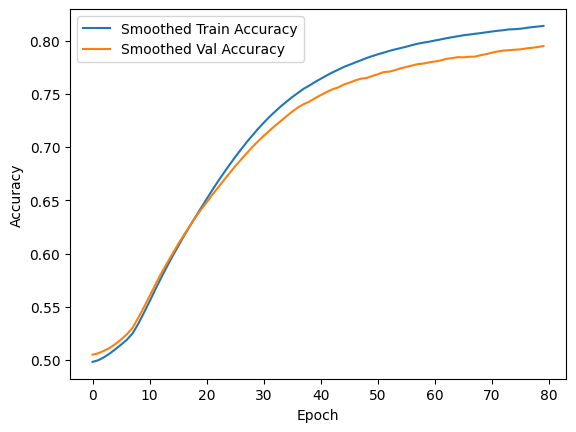

Test Accuracy: 0.7990


In [29]:
### Smoothing out the above graph
import numpy as np
import matplotlib.pyplot as plt

# Define a function for smoothing the data
def smooth_data(data, smoothing_factor=0.9):
    smoothed_data = []
    last_smoothed_point = data[0]
    for point in data:
        smoothed_point = last_smoothed_point * smoothing_factor + point * (1 - smoothing_factor)
        smoothed_data.append(smoothed_point)
        last_smoothed_point = smoothed_point
    return smoothed_data

# Smooth the train and validation losses
smoothed_train_losses = smooth_data(train_losses)
smoothed_val_losses = smooth_data(val_losses)

# Smooth the train and validation accuracies
smoothed_train_accuracies = smooth_data(train_accuracies)
smoothed_val_accuracies = smooth_data(val_accuracies)

# Plotting smoothed train and validation losses
plt.plot(smoothed_train_losses, label='Smoothed Train Loss')
plt.plot(smoothed_val_losses, label='Smoothed Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting smoothed train and validation accuracies
plt.plot(smoothed_train_accuracies, label='Smoothed Train Accuracy')
plt.plot(smoothed_val_accuracies, label='Smoothed Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

## Adding dropout with dropout probability of 0.05 & Weight decay of 3.5e-4

Epoch 1/90, Time: 0.32s, Train Loss: 0.7034, Val Loss: 0.7008, Train Accuracy: 0.5106, Val Accuracy: 0.5010
Epoch 2/90, Time: 0.32s, Train Loss: 0.6950, Val Loss: 0.6937, Train Accuracy: 0.5235, Val Accuracy: 0.5190
Epoch 3/90, Time: 0.33s, Train Loss: 0.6899, Val Loss: 0.6889, Train Accuracy: 0.5346, Val Accuracy: 0.5357
Epoch 4/90, Time: 0.33s, Train Loss: 0.6859, Val Loss: 0.6846, Train Accuracy: 0.5456, Val Accuracy: 0.5540
Epoch 5/90, Time: 0.33s, Train Loss: 0.6816, Val Loss: 0.6801, Train Accuracy: 0.5582, Val Accuracy: 0.5693
Epoch 6/90, Time: 0.33s, Train Loss: 0.6752, Val Loss: 0.6705, Train Accuracy: 0.5747, Val Accuracy: 0.5897
Epoch 7/90, Time: 0.54s, Train Loss: 0.6515, Val Loss: 0.6421, Train Accuracy: 0.6185, Val Accuracy: 0.6325
Epoch 8/90, Time: 0.33s, Train Loss: 0.6332, Val Loss: 0.6368, Train Accuracy: 0.6456, Val Accuracy: 0.6438
Epoch 9/90, Time: 0.34s, Train Loss: 0.6212, Val Loss: 0.6130, Train Accuracy: 0.6613, Val Accuracy: 0.6670
Epoch 10/90, Time: 0.34s, Tr

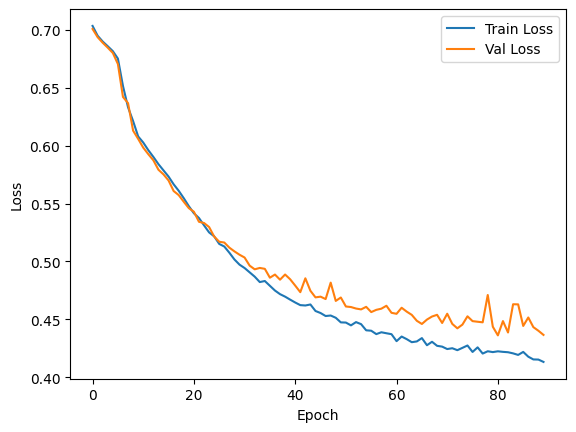

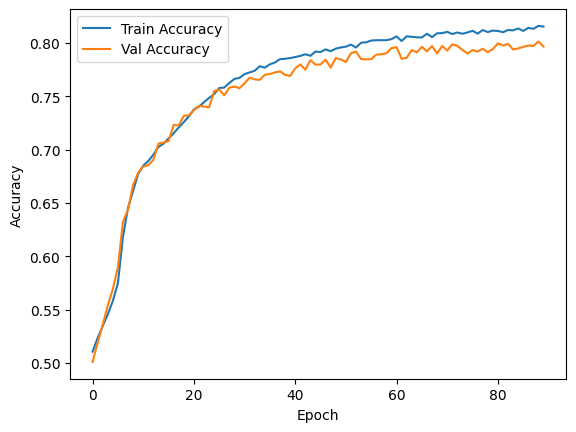

Test Accuracy: 0.7992


In [30]:
# Convert data to PyTorch tensors and move to GPU
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 90

# Instantiate the model and move it to GPU
model = RNNClassifierWithDropout(vocab_size=frequentWord, embedding_dim=embedding_dim, hidden_dim=hidden_dim).to(device)

# Define loss function and optimizer with L2 regularization (weight decay)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=3.5e-4)  # Add weight decay here

# Training loop with gradient clipping
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Adjust max_norm as needed

        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

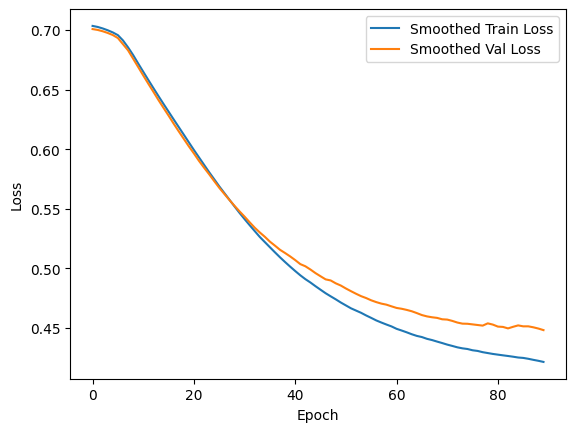

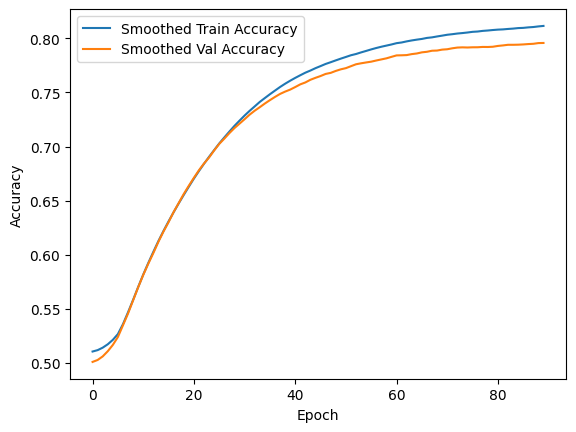

Test Accuracy: 0.7992


In [31]:
### Smoothing out the above graph
import numpy as np
import matplotlib.pyplot as plt

# Define a function for smoothing the data
def smooth_data(data, smoothing_factor=0.9):
    smoothed_data = []
    last_smoothed_point = data[0]
    for point in data:
        smoothed_point = last_smoothed_point * smoothing_factor + point * (1 - smoothing_factor)
        smoothed_data.append(smoothed_point)
        last_smoothed_point = smoothed_point
    return smoothed_data

# Smooth the train and validation losses
smoothed_train_losses = smooth_data(train_losses)
smoothed_val_losses = smooth_data(val_losses)

# Smooth the train and validation accuracies
smoothed_train_accuracies = smooth_data(train_accuracies)
smoothed_val_accuracies = smooth_data(val_accuracies)

# Plotting smoothed train and validation losses
plt.plot(smoothed_train_losses, label='Smoothed Train Loss')
plt.plot(smoothed_val_losses, label='Smoothed Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting smoothed train and validation accuracies
plt.plot(smoothed_train_accuracies, label='Smoothed Train Accuracy')
plt.plot(smoothed_val_accuracies, label='Smoothed Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

## Adding dropout with dropout probability of 0.05 & Weight decay of 3.3e-4
# Best Graph
## Hyperparameters
## Dropout = 0.05
## L2 Regularization = 3.3e-4
## Batch Size = 512
## Learning Rate = 0.0001
## Gradient Clipping = 1.0

Epoch 1/100, Time: 0.34s, Train Loss: 0.7010, Val Loss: 0.6974, Train Accuracy: 0.5046, Val Accuracy: 0.5010
Epoch 2/100, Time: 0.33s, Train Loss: 0.6941, Val Loss: 0.6927, Train Accuracy: 0.5221, Val Accuracy: 0.5195
Epoch 3/100, Time: 0.32s, Train Loss: 0.6895, Val Loss: 0.6895, Train Accuracy: 0.5384, Val Accuracy: 0.5340
Epoch 4/100, Time: 0.32s, Train Loss: 0.6860, Val Loss: 0.6871, Train Accuracy: 0.5470, Val Accuracy: 0.5377
Epoch 5/100, Time: 0.32s, Train Loss: 0.6826, Val Loss: 0.6850, Train Accuracy: 0.5559, Val Accuracy: 0.5483
Epoch 6/100, Time: 0.32s, Train Loss: 0.6783, Val Loss: 0.6819, Train Accuracy: 0.5680, Val Accuracy: 0.5583
Epoch 7/100, Time: 0.32s, Train Loss: 0.6692, Val Loss: 0.6649, Train Accuracy: 0.5879, Val Accuracy: 0.5978
Epoch 8/100, Time: 0.51s, Train Loss: 0.6434, Val Loss: 0.6417, Train Accuracy: 0.6311, Val Accuracy: 0.6462
Epoch 9/100, Time: 0.32s, Train Loss: 0.6279, Val Loss: 0.6313, Train Accuracy: 0.6514, Val Accuracy: 0.6573
Epoch 10/100, Time:

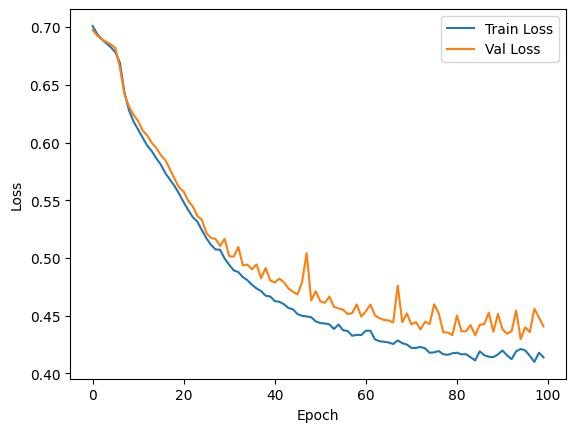

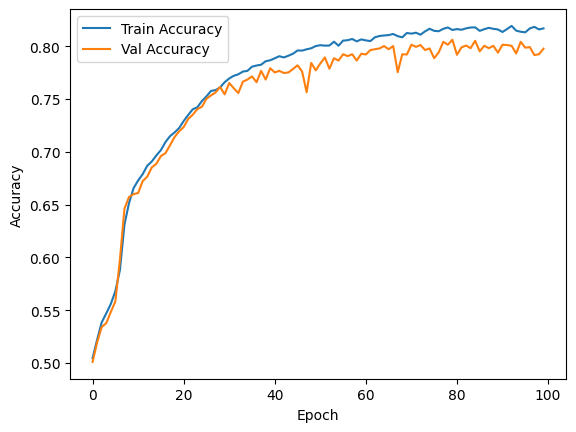

Test Accuracy: 0.8040


In [32]:
# Convert data to PyTorch tensors and move to GPU
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 100

# Instantiate the model and move it to GPU
model = RNNClassifierWithDropout(vocab_size=frequentWord, embedding_dim=embedding_dim, hidden_dim=hidden_dim).to(device)

# Define loss function and optimizer with L2 regularization (weight decay)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=3.3e-4)  # Add weight decay here

# Training loop with gradient clipping
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Adjust max_norm as needed

        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

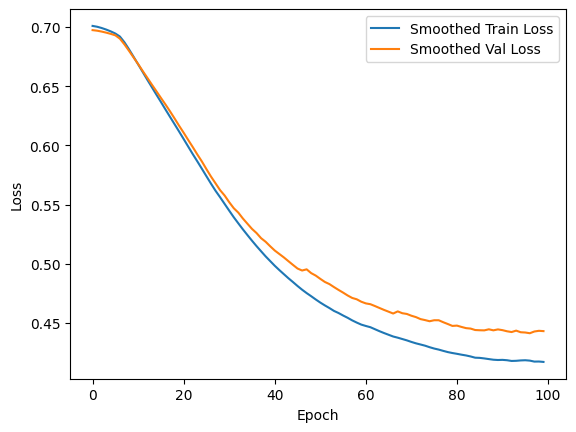

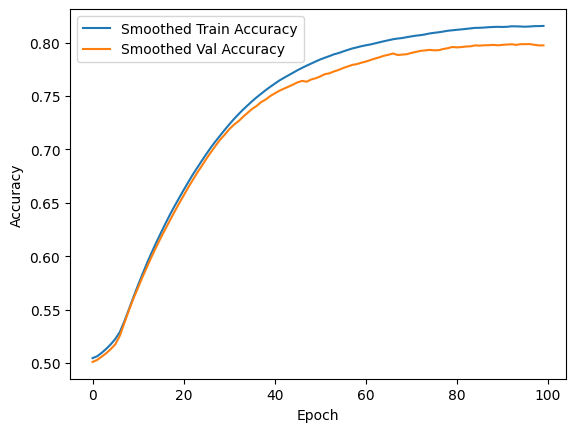

Test Accuracy: 0.8040


In [33]:
### Smoothing out the above graph
import numpy as np
import matplotlib.pyplot as plt

# Define a function for smoothing the data
def smooth_data(data, smoothing_factor=0.9):
    smoothed_data = []
    last_smoothed_point = data[0]
    for point in data:
        smoothed_point = last_smoothed_point * smoothing_factor + point * (1 - smoothing_factor)
        smoothed_data.append(smoothed_point)
        last_smoothed_point = smoothed_point
    return smoothed_data

# Smooth the train and validation losses
smoothed_train_losses = smooth_data(train_losses)
smoothed_val_losses = smooth_data(val_losses)

# Smooth the train and validation accuracies
smoothed_train_accuracies = smooth_data(train_accuracies)
smoothed_val_accuracies = smooth_data(val_accuracies)

# Plotting smoothed train and validation losses
plt.plot(smoothed_train_losses, label='Smoothed Train Loss')
plt.plot(smoothed_val_losses, label='Smoothed Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting smoothed train and validation accuracies
plt.plot(smoothed_train_accuracies, label='Smoothed Train Accuracy')
plt.plot(smoothed_val_accuracies, label='Smoothed Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

## Adding dropout with dropout probability of 0.05 & Weight decay of 3.4e-4

Epoch 1/100, Time: 0.32s, Train Loss: 0.6991, Val Loss: 0.6911, Train Accuracy: 0.5081, Val Accuracy: 0.5337
Epoch 2/100, Time: 0.33s, Train Loss: 0.6919, Val Loss: 0.6858, Train Accuracy: 0.5270, Val Accuracy: 0.5533
Epoch 3/100, Time: 0.33s, Train Loss: 0.6873, Val Loss: 0.6818, Train Accuracy: 0.5427, Val Accuracy: 0.5640
Epoch 4/100, Time: 0.32s, Train Loss: 0.6839, Val Loss: 0.6780, Train Accuracy: 0.5521, Val Accuracy: 0.5795
Epoch 5/100, Time: 0.34s, Train Loss: 0.6794, Val Loss: 0.6732, Train Accuracy: 0.5631, Val Accuracy: 0.5867
Epoch 6/100, Time: 0.31s, Train Loss: 0.6727, Val Loss: 0.6639, Train Accuracy: 0.5795, Val Accuracy: 0.5960
Epoch 7/100, Time: 0.32s, Train Loss: 0.6520, Val Loss: 0.6392, Train Accuracy: 0.6178, Val Accuracy: 0.6325
Epoch 8/100, Time: 0.52s, Train Loss: 0.6354, Val Loss: 0.6390, Train Accuracy: 0.6418, Val Accuracy: 0.6285
Epoch 9/100, Time: 0.33s, Train Loss: 0.6304, Val Loss: 0.6261, Train Accuracy: 0.6450, Val Accuracy: 0.6465
Epoch 10/100, Time:

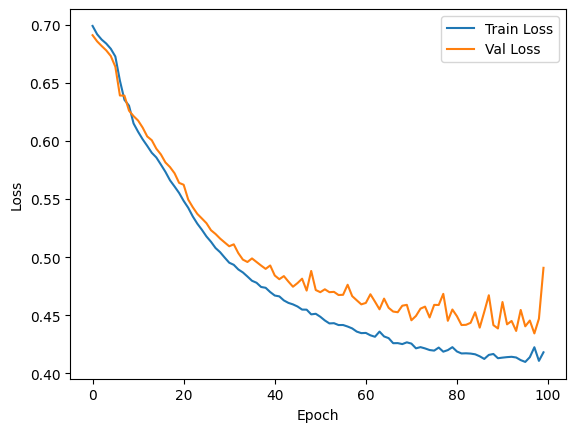

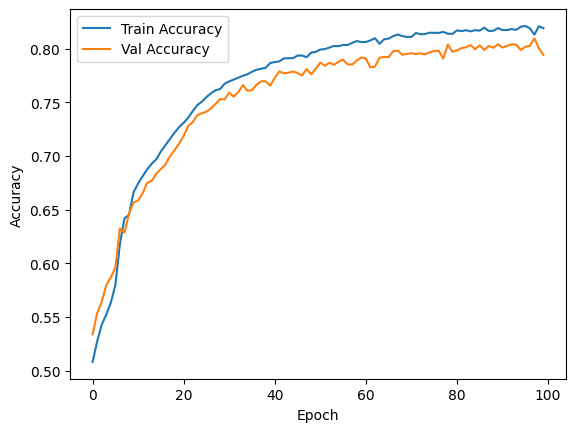

Test Accuracy: 0.7924


In [34]:
# Convert data to PyTorch tensors and move to GPU
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 100

# Instantiate the model and move it to GPU
model = RNNClassifierWithDropout(vocab_size=frequentWord, embedding_dim=embedding_dim, hidden_dim=hidden_dim).to(device)

# Define loss function and optimizer with L2 regularization (weight decay)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=3.4e-4)  # Add weight decay here

# Training loop with gradient clipping
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Adjust max_norm as needed

        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

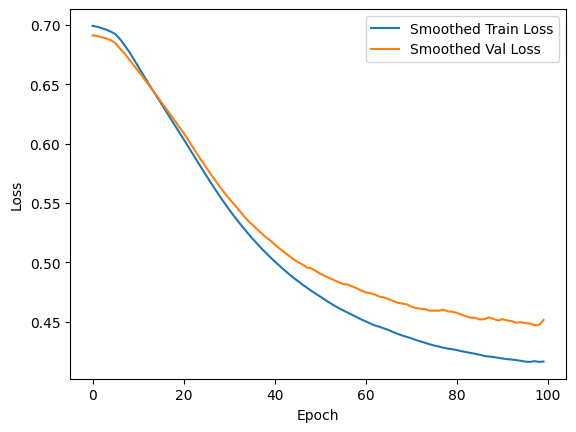

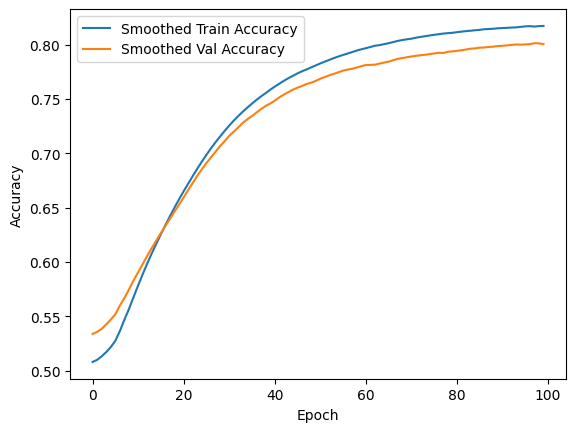

Test Accuracy: 0.7924


In [35]:
### Smoothing out the above graph
import numpy as np
import matplotlib.pyplot as plt

# Define a function for smoothing the data
def smooth_data(data, smoothing_factor=0.9):
    smoothed_data = []
    last_smoothed_point = data[0]
    for point in data:
        smoothed_point = last_smoothed_point * smoothing_factor + point * (1 - smoothing_factor)
        smoothed_data.append(smoothed_point)
        last_smoothed_point = smoothed_point
    return smoothed_data

# Smooth the train and validation losses
smoothed_train_losses = smooth_data(train_losses)
smoothed_val_losses = smooth_data(val_losses)

# Smooth the train and validation accuracies
smoothed_train_accuracies = smooth_data(train_accuracies)
smoothed_val_accuracies = smooth_data(val_accuracies)

# Plotting smoothed train and validation losses
plt.plot(smoothed_train_losses, label='Smoothed Train Loss')
plt.plot(smoothed_val_losses, label='Smoothed Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting smoothed train and validation accuracies
plt.plot(smoothed_train_accuracies, label='Smoothed Train Accuracy')
plt.plot(smoothed_val_accuracies, label='Smoothed Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

In [36]:
## conda install nomkl